# L1 spectrum value check

> Check that all L1 spectra have valid flux/ivar/sensfunc arrays.

In [ ]:
# |default_exp diagnostics.l1_spectrum_value_check

In [ ]:
# |export

import matplotlib.pyplot as plt
import numpy as np

from qagmire.data import (
    get_lr_l1_single_files,
    read_l1_data,
)
from qagmire.quality_assurance import Diagnostics

To write checks of the data, we create a subclass of `Diagnostics` and implement the `tests` method.

In [ ]:
# |export


class L1SpectrumValueCheck(Diagnostics):
    """L1 spectrum value check.

    A reproduction of the class with the same name in the weaveio
    [value_checks](https://github.com/bamford/QAG/blob/master/diagnostics/value_checks.py).

    This tests for the following cases:

    * Are there non-finite pixel values?

    for the red and blue 'flux', 'flux_noss', 'ivar', 'ivar_noss' and 'sensfunc' arrays, as well as:

    * Are there negative pixel values?

    for the red and blue 'ivar', 'ivar_noss' and 'sensfunc' arrays.
    """

    def __init__(
        self,
        n_allowed_bad: int = 0,  # the number of allowed bad pixels per spectrum
        camera=None,  # limit to a specific camera: RED or BLUE
        **kwargs,  # additional keyword arguments are passed to the `Diagnostics` constructor
    ):
        self.n_allowed_bad = n_allowed_bad
        self.camera = camera.upper()
        super().__init__(**kwargs)

    def tests(self, **kwargs):
        files = get_lr_l1_single_files(**kwargs)
        data = read_l1_data(files)

        if self.camera is not None:
            camera_match = data["CAMERA"] == self.camera
            data = data.sel(filename=camera_match)
            cameras = [self.camera]
        else:
            cameras = ["RED", "BLUE"]

        # perform the tests by RUN, rather than filename
        data = data.swap_dims(filename="RUN")
        self.data = data

        neg = data < 0
        nan = ~np.isfinite(data)

        any_neg = neg.any(dim=["LAMBDA_R", "LAMBDA_B"])
        any_nan = nan.any(dim=["LAMBDA_R", "LAMBDA_B"])

        tests = []
        for camera in cameras:
            camera_match = data["CAMERA"] == camera
            for ext in ["FLUX", "FLUX_NOSS", "IVAR", "IVAR_NOSS", "SENSFUNC"]:
                name = f"{camera}_{ext}"
                tests.append(
                    {
                        "name": f"nans_in_{name}",
                        "description": f"Are there non-finite values in {name}?",
                        "test": any_nan[name] & camera_match,
                    }
                )
            for ext in ["IVAR", "IVAR_NOSS", "SENSFUNC"]:
                name = f"{camera}_{ext}"
                tests.append(
                    {
                        "name": f"negs_in_{name}",
                        "description": f"Are there negative values in {name}?",
                        "test": any_neg[name] & camera_match,
                    }
                )
        return tests

## Demonstration tests

We use multiple `dask` workers to speed up this test. Checking 15 billion pixels takes ~45 seconds with 8 workers. You may need to increase the `memory_limit` per worker (as below) if you see warnings.

### Red camera

In [ ]:
red_tests = L1SpectrumValueCheck(camera="RED", n_processes=8)
red_tests.run(date="201*")

Locating and converting where necessary: 100%|██████████| 126/126 [00:00<00:00, 4804.87it/s]
Reading netCDF files... took 32.70 s. Size is 57535.390 Mb
Tests took 33.41 s to perform.
nans_in_RED_FLUX:
    Are there non-finite values in RED_FLUX?
nans_in_RED_FLUX_NOSS:
    Are there non-finite values in RED_FLUX_NOSS?
nans_in_RED_IVAR:
    Are there non-finite values in RED_IVAR?
nans_in_RED_IVAR_NOSS:
    Are there non-finite values in RED_IVAR_NOSS?
nans_in_RED_SENSFUNC:
    Are there non-finite values in RED_SENSFUNC?
negs_in_RED_IVAR:
    Are there negative values in RED_IVAR?
negs_in_RED_IVAR_NOSS:
    Are there negative values in RED_IVAR_NOSS?
negs_in_RED_SENSFUNC:
    Are there negative values in RED_SENSFUNC?


In [ ]:
red_tests.summary(by="RUN")

failed                                         \
test    nans_in_RED_FLUX nans_in_RED_FLUX_NOSS nans_in_RED_IVAR   
RUN                                                               
1004097              960                   960              960   
1004099              960                   960              960   
1004101              960                   960              960   
1004109              960                   960              960   
1004111              960                   960              960   
1004113              960                   960              960   
1004121              960                   960              960   
1004123              960                   960              960   
1004125              960                   960              960   
1004145              960                   960              960   
1004147              960                   960              960   
1004149              960                   960              960   
1002249               20                    20               20   
1002251               20                    20               20   
1002253               20                    20               20   
1002261               20                    20               20   
1002263               20                    20               20   
1002265               20                    20               20   
1002285               20                    20               20   
1002287               20                    20               20   
1002289               20                    20               20   
1002309               20                    20               20   
1002311               20                    20               20   
1002313               20                    20               20   
1002321               20                    20               20   
1002323               20                    20               20   
1002325               20                    20               20   
1002345               20                    20               20   
1002347               20                    20               20   
1002349               20                    20               20   
1003329               20                    20               20   
1003331               20                    20               20   
1003333               20                    20               20   
1003353               20                    20               20   
1003355               20                    20               20   
1003357               20                    20               20   
1003437               20                    20               20   
1003439               20                    20               20   
1003441               20                    20               20   

                                                   total fails  
test    nans_in_RED_IVAR_NOSS nans_in_RED_SENSFUNC              
RUN                                                             
1004097                   960                  960        4800  
1004099                   960                  960        4800  
1004101                   960                  960        4800  
1004109                   960                  960        4800  
1004111                   960                  960        4800  
1004113                   960                  960        4800  
1004121                   960                  960        4800  
1004123                   960                  960        4800  
1004125                   960                  960        4800  
1004145                   960                  960        4800  
1004147                   960                  960        4800  
1004149                   960                  960        4800  
1002249                    20                   20         100  
1002251                    20                   20         100  
1002253                    20                   20         100  
1002261                    20    

In [ ]:
red_tests.summary(by="NSPEC")

failed                                         \
test  nans_in_RED_FLUX nans_in_RED_FLUX_NOSS nans_in_RED_IVAR   
NSPEC                                                           
941                 39                    39               39   
942                 39                    39               39   
943                 39                    39               39   
944                 39                    39               39   
945                 39                    39               39   
...                ...                   ...              ...   
936                 12                    12               12   
937                 12                    12               12   
938                 12                    12               12   
939                 12                    12               12   
940                 12                    12               12   

                                                 total fails  
test  nans_in_RED_IVAR_NOSS nans_in_RED_SENSFUNC              
NSPEC                                                         
941                      39                   39         195  
942                      39                   39         195  
943                      39                   39         195  
944                      39                   39         195  
945                      39                   39         195  
...                     ...                  ...         ...  
936                      12                   12          60  
937                      12                   12          60  
938                      12                   12          60  
939                      12                   12          60  
940                      12                   12          60  

[960 rows x 6 columns]

### Blue camera

In [ ]:
blue_tests = L1SpectrumValueCheck(camera="BLUE", n_processes=8)
blue_tests.run(date="2017*")

Locating and converting where necessary: 100%|██████████| 60/60 [00:00<00:00, 4790.39it/s]
Reading netCDF files... took 2.97 s. Size is 27397.908 Mb
Tests took 25.52 s to perform.
nans_in_BLUE_FLUX:
    Are there non-finite values in BLUE_FLUX?
nans_in_BLUE_FLUX_NOSS:
    Are there non-finite values in BLUE_FLUX_NOSS?
nans_in_BLUE_IVAR:
    Are there non-finite values in BLUE_IVAR?
nans_in_BLUE_IVAR_NOSS:
    Are there non-finite values in BLUE_IVAR_NOSS?
nans_in_BLUE_SENSFUNC:
    Are there non-finite values in BLUE_SENSFUNC?
negs_in_BLUE_IVAR:
    Are there negative values in BLUE_IVAR?
negs_in_BLUE_IVAR_NOSS:
    Are there negative values in BLUE_IVAR_NOSS?
negs_in_BLUE_SENSFUNC:
    Are there negative values in BLUE_SENSFUNC?


In [ ]:
blue_tests.summary(by="RUN")

failed                                           \
test    nans_in_BLUE_FLUX nans_in_BLUE_FLUX_NOSS nans_in_BLUE_IVAR   
RUN                                                                  
1004098               960                    960               960   
1004100               960                    960               960   
1004102               960                    960               960   
1004110               960                    960               960   
1004112               960                    960               960   
1004114               960                    960               960   
1004122               960                    960               960   
1004124               960                    960               960   
1004126               960                    960               960   
1004146               960                    960               960   
1004148               960                    960               960   
1004150               960                    960               960   
1003330                20                     20                20   
1003332                20                     20                20   
1003334                20                     20                20   
1003354                20                     20                20   
1003356                20                     20                20   
1003358                20                     20                20   
1003438                20                     20                20   
1003440                20                     20                20   
1003442                20                     20                20   

                                                     total fails  
test    nans_in_BLUE_IVAR_NOSS nans_in_BLUE_SENSFUNC              
RUN                                                               
1004098                    960                   960        4800  
1004100                    960                   960        4800  
1004102                    960                   960        4800  
1004110                    960                   960        4800  
1004112                    960                   960        4800  
1004114                    960                   960        4800  
1004122                    960                   960        4800  
1004124                    960                   960        4800  
1004126                    960                   960        4800  
1004146                    960                   960        4800  
1004148                    960                   960        4800  
1004150                    960                   960        4800  
1003330                     20                    20         100  
1003332                     20                    20         100  
1003334                     20                    20         100  
1003354                     20                    20         100  
1003356                     20                    20         100  
1003358                     20                    20         100  
1003438                     20                    20         100  
1003440                     20                    20         100  
1003442                     20                    20         100

In [ ]:
blue_tests.summary(by="NSPEC")

failed                                           \
test  nans_in_BLUE_FLUX nans_in_BLUE_FLUX_NOSS nans_in_BLUE_IVAR   
NSPEC                                                              
941                  21                     21                21   
942                  21                     21                21   
943                  21                     21                21   
944                  21                     21                21   
945                  21                     21                21   
...                 ...                    ...               ...   
936                  12                     12                12   
937                  12                     12                12   
938                  12                     12                12   
939                  12                     12                12   
940                  12                     12                12   

                                                   total fails  
test  nans_in_BLUE_IVAR_NOSS nans_in_BLUE_SENSFUNC              
NSPEC                                                           
941                       21                    21         105  
942                       21                    21         105  
943                       21                    21         105  
944                       21                    21         105  
945                       21                    21         105  
...                      ...                   ...         ...  
936                       12                    12          60  
937                       12                    12          60  
938                       12                    12          60  
939                       12                    12          60  
940                       12                    12          60  

[960 rows x 6 columns]

## Verification

We now do some spot checks to verify and expand upon the above test results. Note that we assigned `self.data` inside `tests`. This provides a way of accessing the source data, without having to construct it again.

Note that the `neg_` tests are omitted from the summaries above, which means they all passed.

In [ ]:
def plot(data, run, ext):
    qty = data.sel(RUN=run)[ext]
    fig, ax = plt.subplots(2, 1, figsize=(15, 4), sharex=True, sharey=True)
    ax[0].imshow(qty, vmin=0, vmax=100, interpolation="none", aspect="auto")
    ax[0].set_title(ext)
    ax[1].imshow(~np.isfinite(qty), interpolation="none", aspect="auto")
    ax[1].set_title("NaNs")
    fig.suptitle(f"RUN {run}")
    plt.tight_layout()

There is some odd striping of NaN values in the spectra with many failures (@fig-bad), but those with few failures just have a small number of spectra that are completely NaN (@fig-good).

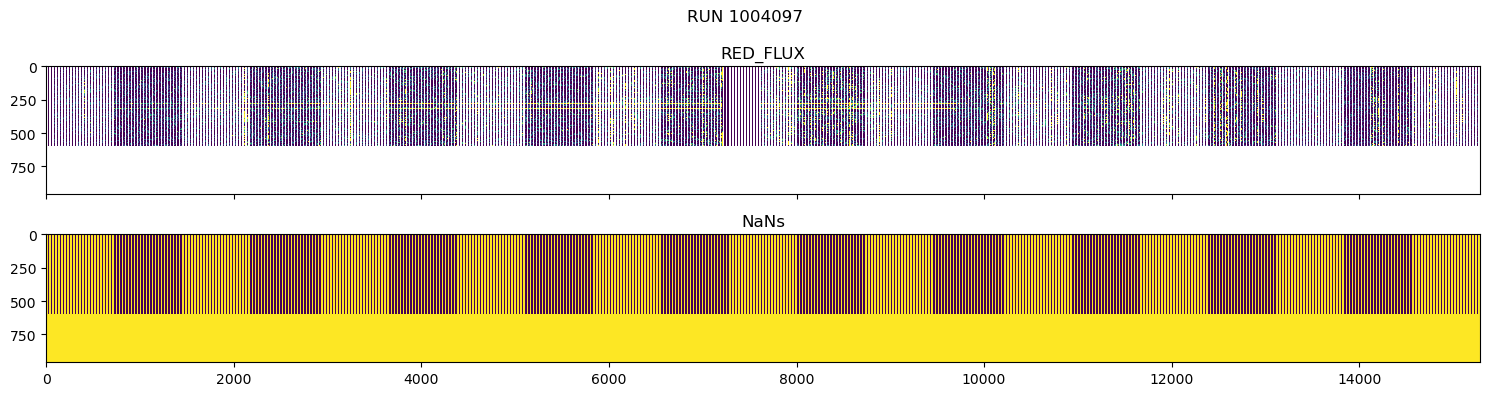

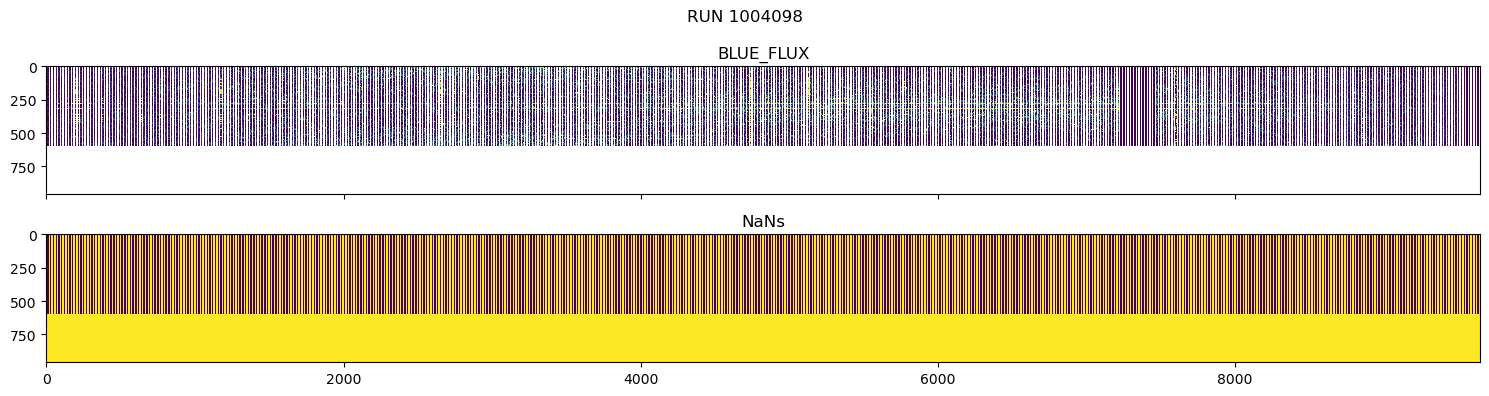

In [ ]:
# |label: fig-bad
plot(red_tests.data, 1004097, "RED_FLUX")
plot(blue_tests.data, 1004098, "BLUE_FLUX")

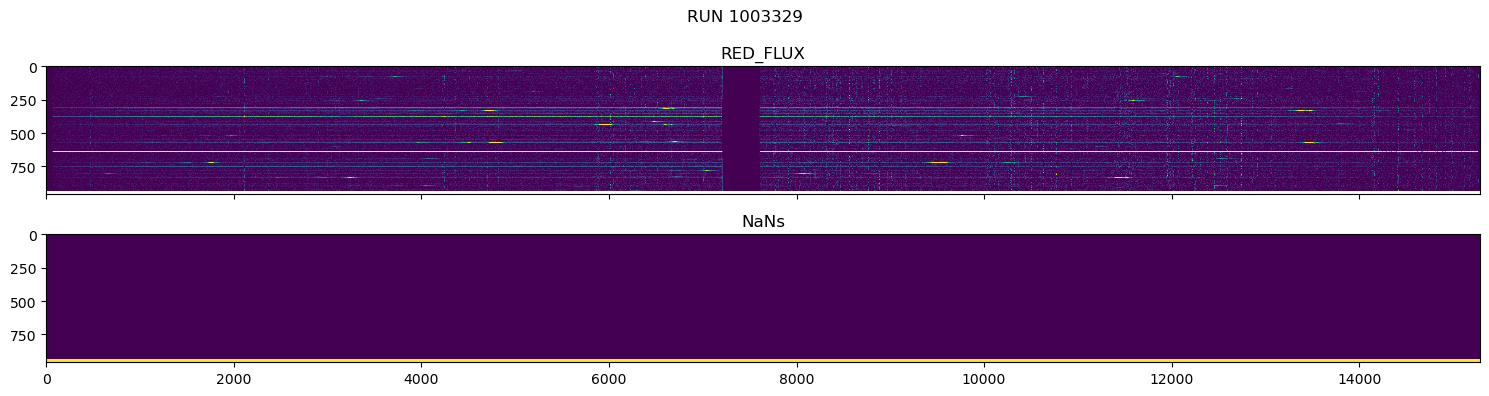

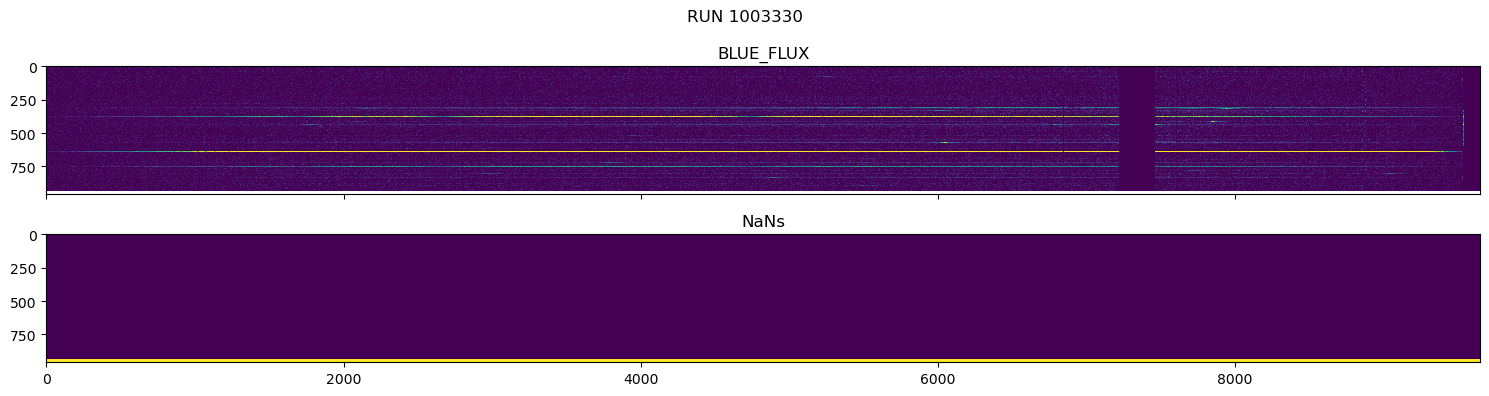

In [ ]:
# |label: fig-good
plot(red_tests.data, 1003329, "RED_FLUX")
plot(blue_tests.data, 1003330, "BLUE_FLUX")

In [ ]:
# |hide
import nbdev

nbdev.nbdev_export()